# Homework 3
---------------------------------------------------------------------
## CIS 600 Fundamental Data & Knowledge Mining
## Prof. Ying Lin
## 11/19/2022

### Anthony Redamonti
### Syracuse University

### Section 1: Introduction 
The following project was implemented in Jupyter Notebooks using Anaconda 3 with Python 3 (ipykernel). The goal of the project is to build various models that are designed to solve a binary classification problem: Based on the training dataset, predict which patients in the test dataset will contract the disease.

Analyze the dataset provided in the file "Disease Prediction Training.csv."
- Data Preparation & EDA
- Build, Tune, and Evaluate Various Machine Learning Algorithms
    - Naive Bayes Classifier (NBC)
    - K Nearest Neighbors (KNN)
    - Random Forest
    - Grandient Boosting Machine (GBM)

Apply the classification models on the test dataset "Disease Prediction Testing.csv."
- Model Prediction

### Section 2: Data Preparation & EDA
- Handle Outliers
- Data Normalization
- Replace Entries with Missing Data
- Format Gender Attribute 
- One-hot Encoding
- Data Standardization/Normalization
- EDA: Heatmap

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as mtpltlib

trainingData = pd.read_csv('Disease Prediction Training.csv')

print("(Rows, Columns): ", trainingData.shape)

(Rows, Columns):  (49000, 12)


#### Section 2.1: Handle Outliers

Certain features must be checked for outliers. 

An outlier will be defined in the following manner:
- The IQR must be found. The IQR is defined as the difference between the 75th and 25th percentiles of the data.
- Once the IQR is found, it is used to find the upper and lower thresholds that will be used to find outliers.
- The upper threshold is: 75th percentile + (1.5 * IQR)
- The lower threshold is: 25th percentile - (1.5 * IQR)

Find the total number of entries that contain outliers in the dataset. First, the following numeric ratio features will be checked for outliers: 
- Age, Height, Weight, High Blood Pressure, and Low Blood Pressure.

In [2]:
# Function that returns the indices of all the outliers in the dataset.
# Arguments are the dataset and a list of features.
def findOutlierIndexList(dataframe, inputFeatureList):
    
    outlierList = []
    
    for feature in inputFeatureList:
        quantile1 = dataframe[feature].quantile(0.25)
        quantile3 = dataframe[feature].quantile(0.75)
        interquartileRange = quantile3 - quantile1
        lowerThreshhold = quantile1 - (1.5 * interquartileRange)
        upperThreshhold = quantile3 + (1.5 * interquartileRange)
        
        index = 0
        
        # search the feature for outliers
        while(index < len(dataframe) - 1):
            value = dataframe._get_value(index, feature)
            if((value < lowerThreshhold) or (value > upperThreshhold)):
                outlierList.append(index)
            index = index + 1
                
    # remove repeating indices.
    outlierList = sorted(set(outlierList))
    return outlierList

# Define a list of numeric ratio features that may have outliers. 
ratioFeatureList = ['Age', 'Height', 'Weight', 'High Blood Pressure', 'Low Blood Pressure']

# Find the total number of outliers in the dataset.
outlierIndexList = findOutlierIndexList(trainingData, ratioFeatureList)
totalNumberOfOutliers = len(outlierIndexList)
print("Percentage of Outliers:", '{:.2%}'.format(totalNumberOfOutliers / len(trainingData)))

Percentage of Outliers: 10.71%


#### 10.71% of the entries in the numeric ratio features contain outliers. 

#### The outliers will be clipped so that they will fall within the range of acceptable values. 
- Any value greater than the upper threshold will be set equal to the upper threshold.
- Any value less than the lower threshold will be set equal to the lower threshold.
- The upper threshold is: 75th percentile + (1.5 * IQR)
- The lower threshold is: 25th percentile - (1.5 * IQR)

In [3]:
# Function that clips the value of outliers in the dataset.
# Arguments are the original dataset and a list of selected features.
def clipOutliers(dataframe, inputFeatureList):
    for feature in inputFeatureList:
        quantile1 = dataframe[feature].quantile(0.25)
        quantile3 = dataframe[feature].quantile(0.75)
        interquartileRange = quantile3 - quantile1
        lowerThreshhold = quantile1 - (1.5 * interquartileRange)
        upperThreshhold = quantile3 + (1.5 * interquartileRange)
        index = 0
    
        # search the feature for outliers
        while(index < len(dataframe) - 1):
            value = dataframe._get_value(index, feature)
            if(value < lowerThreshhold):
                dataframe._set_value(index, feature, lowerThreshhold)            
            if(value > upperThreshhold):
                dataframe._set_value(index, feature, upperThreshhold)            
            index = index + 1 

# clip the values of the outliers.
clipOutliers(trainingData, ratioFeatureList)

# Find the total number of outliers in the dataset.
print("Total number of outliers found after clipping: ", len(findOutlierIndexList(trainingData, ratioFeatureList)))

Total number of outliers found after clipping:  0


#### Section 2.2 Data Normalization
- The numeric ratio attribute must be normalized so that their values fall within the range of 0 and 1. 
- Due to the nature of the distance based machine learning algorithms, the numeric ratio attributes must fall within this range. If the data were not normalized, the features would not be properly balanced (improperly weighted).

<AxesSubplot:xlabel='High Blood Pressure', ylabel='Count'>

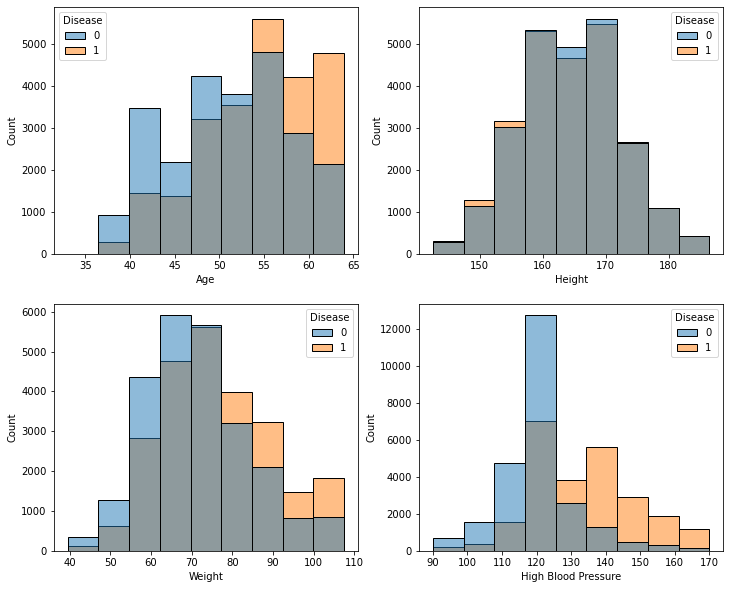

In [4]:
fig, axs = mtpltlib.subplots(2, 2, figsize=(12, 10))
sbn.histplot(data = trainingData, x="Age", hue="Disease", bins = 9, ax=axs[0, 0])
sbn.histplot(data = trainingData, x="Height", hue="Disease", bins = 9, ax=axs[0, 1])
sbn.histplot(data = trainingData, x="Weight", hue="Disease", bins = 9, ax = axs[1, 0])
sbn.histplot(data = trainingData, x="High Blood Pressure", hue="Disease", bins = 9, ax = axs[1, 1])

<AxesSubplot:xlabel='High Blood Pressure', ylabel='Count'>

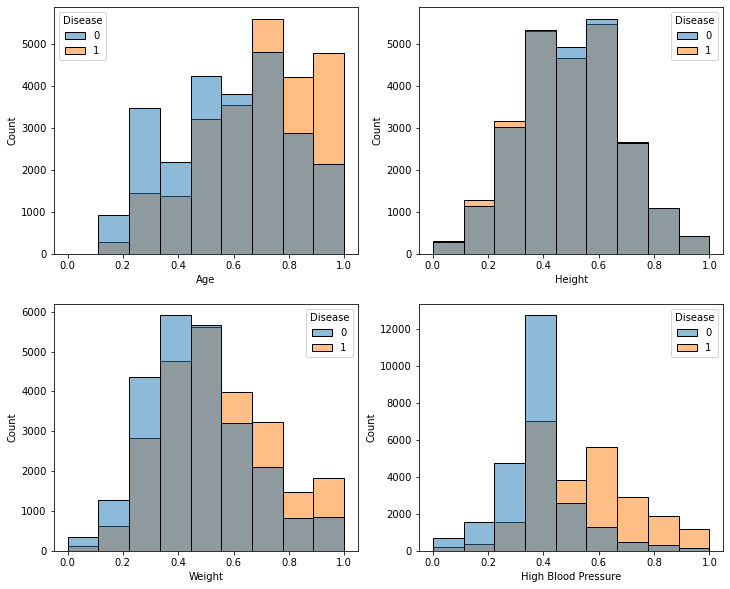

In [5]:
# Normalize the features in the input feature list of the dataframe.
# Values will be normalized between 0 and 1.
# Arguments are the dataframe and the input feature list.
def normalizeDataset(dataframe, inputFeatureList):
    for feature in inputFeatureList:

        # scale between -1 and 1
        absMax = dataframe[feature].abs().max()
        dataframe[feature] = dataframe[feature] / absMax
        
        # scale between 0 and 1
        minimum = dataframe[feature].min()
        maximum = dataframe[feature].max()
        difference = maximum - minimum
        dataframe[feature] = (dataframe[feature] - minimum) / difference

normalizeDataset(trainingData, ratioFeatureList)

fig, axs = mtpltlib.subplots(2, 2, figsize=(12, 10))
sbn.histplot(data = trainingData, x="Age", hue="Disease", bins = 9, ax=axs[0, 0])
sbn.histplot(data = trainingData, x="Height", hue="Disease", bins = 9, ax=axs[0, 1])
sbn.histplot(data = trainingData, x="Weight", hue="Disease", bins = 9, ax = axs[1, 0])
sbn.histplot(data = trainingData, x="High Blood Pressure", hue="Disease", bins = 9, ax = axs[1, 1])

- The histograms above illustrate that the numeric ratio data has been normalized in the range [0, 1].

#### Section 2.3: Replace Entries with Missing Data
- The summary below displays the total number of NULL entries for each feature.

In [6]:
trainingData.isnull().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64

##### There are no entries with missing data.

#### Section 2.4: Format Gender Attribute
- The format of the gender attribute will be transformed from Male/Female to 1/0 numeric format for model building.

In [7]:
trainingData['Gender'] = trainingData['Gender'].replace("female", 0)
trainingData['Gender'] = trainingData['Gender'].replace("male", 1)

#### Section 2.5: One-Hot Encoding
- "Glucose" and "Cholesterol" need to be transformed using one-hot encoding.
- After the one-hot encoded columns are added to the dataset, the original feature columns "Glucose" and "Cholesterol" will be removed as they are no longer needed.

In [8]:
# concatenate the one-hot encoding to the original dataframe
newCholesterol = pd.get_dummies(trainingData.Cholesterol, prefix='Cholesterol')
trainingData = pd.concat([trainingData, newCholesterol], axis = 1)
newGlucose = pd.get_dummies(trainingData.Glucose, prefix='Glucose')
trainingData = pd.concat([trainingData, newGlucose], axis = 1)

# remove old nominal columns
nominalFeatureList = ['Cholesterol', 'Glucose']
for feature in nominalFeatureList:
    trainingData.drop(feature, inplace = True, axis = 1)

#### Section 2.6: Data Standardization/Normalization
- The numeric ratio features will be standardized and normalized before the dataframe can be used to build any models.
- The fit_transform method of the scaler class is used to fit and transform a dataframe's features independently. 
- After transformation, each numeric ratio feature will have:
    - Mean == 0
    - Variance == 1

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from numpy import mean
from numpy import var

# separate the target feature from the training dataset
y = trainingData['Disease']
trainingData.drop('Disease', inplace = True, axis = 1)
X = trainingData

scaler = StandardScaler()

# create a dataframe with only the numeric ratio features.
X_ratio = pd.DataFrame()
for feature in ratioFeatureList:
    X_ratio = pd.concat([X_ratio, trainingData[feature]], axis = 1)

# fit and transform the features.
X_ratio_scaled = scaler.fit_transform(X_ratio)

# convert the numpy array to dataframe
X_ratio_scaled_df = pd.DataFrame(X_ratio_scaled)

# name the columns of the dataframe
X_ratio_scaled_df.columns = ratioFeatureList

# overwrite the old numeric ratio features with the transformed numeric ratio features.
for feature in ratioFeatureList:
    X[feature] = X_ratio_scaled_df[feature]

In [10]:
print("MEAN OF NUMERIC RATIO FEATURES:")
mean(X_ratio_scaled_df, axis = 0)

MEAN OF NUMERIC RATIO FEATURES:


Age                   -1.789856e-16
Height                -2.455859e-17
Weight                 3.340910e-16
High Blood Pressure   -1.735131e-16
Low Blood Pressure     2.251714e-17
dtype: float64

In [11]:
print("VARIANCE OF NUMERIC RATIO FEATURES:")
var(X_ratio_scaled_df, axis = 0)

VARIANCE OF NUMERIC RATIO FEATURES:


Age                    1.0
Height                 1.0
Weight                 1.0
High Blood Pressure    1.0
Low Blood Pressure     1.0
dtype: float64

- After standardization/normalization, the numeric ratio features have the following properties:
    - The mean is approximately zero.
    - The variance is 1.0.

#### Section 2.7: Heatmap (EDA)
- A heatmap will be created to show the correlations between different attributes.

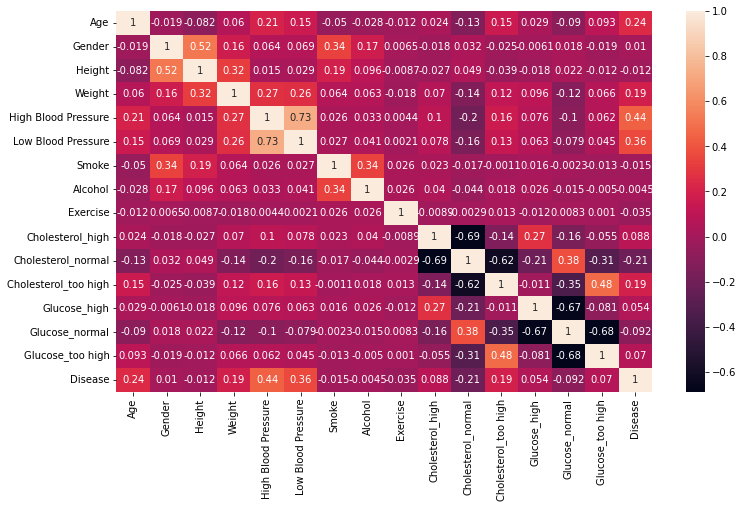

In [12]:
# append the feature back into the dataset
X['Disease'] = y

# create the heatmap
importantAttributes = X[X.columns]
mtpltlib.figure(figsize=(12,7))
correlation = importantAttributes.corr()
sbn.heatmap(correlation, annot = True)

# remove the target feature.
X.drop('Disease', inplace = True, axis = 1)

- The five attributes with the highest correlation with the disease are High Blood Pressure, Low Blood Pressure, Age, Weight, and Cholesterol_too high.

### Section 3: Build, Tune, and Evaluate Various Machine Learning Models

#### Section 3.1: Train_test_split 
- The data will now be divided for model building using train_test_split.
- X_train represents 70% of the training dataset used for training purposes. 
- X_test represent 30% of the training dataset used for testing purposes.
- X_test is really the validation dataset because it originates from the training dataset. The testing dataset will be used later by loading a seperate CSV file.
- y_train represents the label "Disease" in the dataset, which is known.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

#### Section 3.2: Building a K-Nearest Neighbors (KNN) Model
- The KNN model is a distance-based machine learning algorithm used for solving regression and classification problems.
- It assumes entries belong to the same group as those closest to it. 
- The K in KNN is the hyperparameter that specifies how many nearest neighbors to consider when classifying an entry.
- X_train and y_train are used in clf.fit to build a KNN model.
- Once the model is built, it is used to predict the Disease label using X_test. 

In [14]:
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

clfKnn = KNeighborsClassifier()
clfKnn.fit(X_train, y_train)
y_pred = clfKnn.predict(X_test)

print(f"Accuracy: {round( metrics.accuracy_score(y_test, y_pred) * 100, 2)}%")
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion

Accuracy: 69.82%


col_0,0,1
Disease,,
0,5204,2094
1,2343,5059


##### The accuracy of the KNN model is 69.82%. The model will now be tested using two forms of cross-validation to improve performance.
- The two methods of cross-validation to be tested are: ShuffleSplit and KFold.
##### ShuffleSplit Method
- Shufflesplit is a method of sampling data during the cross-validation stage. 
- It will randomly sample data for each iteration.
- It will be used below to generate random samples of training/validation data. 
- The size of the data samples is set using the test_size parameter.
- The number of sections to split the data is set by the n_splits parameter.
##### KFold Method
- K-fold is a method of sampling data during the cross-validation stage.
- It will divide the samples into K number of sections. 
- One section will be for validation purposes. 
- The remaining sections will be for training purposes.
- The sections are swapped between iterations.
- The number K is set using the n_splits parameter.

In [15]:
# Get Repeated Hold Out Accuracy of Model
from sklearn.model_selection import KFold, ShuffleSplit

crossValShuffSplit = ShuffleSplit(n_splits = 15, test_size = 0.3, random_state=20)
accuracyShuffSplit = cross_val_score(clfKnn, X_train, y_train, cv=crossValShuffSplit).mean()*100
accuracyShuffSplit = round(accuracyShuffSplit, 2)
print("Accuracy using ShuffleSplit cross validation: " + str(accuracyShuffSplit))

crossValKFold = KFold(n_splits = 15, shuffle = True, random_state=20)
accuracyKFold = cross_val_score(clfKnn, X_train, y_train, cv=crossValKFold).mean()*100
accuracyKFold = round(accuracyKFold, 2)
print("Accuracy using KFold cross validation: " + str(accuracyKFold))

Accuracy using ShuffleSplit cross validation: 69.65
Accuracy using KFold cross validation: 69.75


##### ShuffleSplit Accuracy: 69.65%
##### K-Fold Accuracy: 69.75%
- The KFold method of cross-validation out-performed the ShuffleSplit method.
- The KFold method of cross-validation will be selected for future hyperparameter tuning.

##### Sensitivity Analysis: The model will now be tested using various nearest neighbors.
- Sensitivitiy analysis will now be performed on various values of nearest neighbors.
- The accuracy will be plotted on a 2D plot for each neighbor value tested.

1 nearest neighbors produced 64.49% test accuracy.
3 nearest neighbors produced 68.19% test accuracy.
10 nearest neighbors produced 71.65% test accuracy.
20 nearest neighbors produced 72.69% test accuracy.


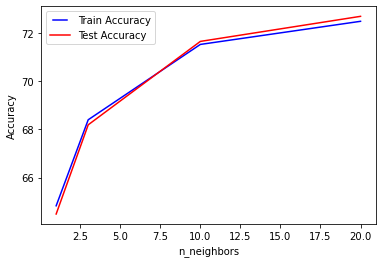

In [16]:
## Sensitivity Analysis 
from matplotlib.legend_handler import HandlerLine2D

neighbors = [1, 3, 10, 20]
train_results = []
test_results = [] 
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    accuracy_train = cross_val_score(model, X_train, y_train, cv = crossValKFold).mean() * 100
    train_results.append(accuracy_train)
    y_pred = model.predict(X_test)
    accuracy_test = round(metrics.accuracy_score(y_test, y_pred)*100, 2)
    test_results.append(accuracy_test)
    print(str(n)+ " nearest neighbors produced "+ str(accuracy_test) + "% test accuracy.")
    
line1, = plt.plot(neighbors, train_results, 'b', label = "Train Accuracy")
line2, = plt.plot(neighbors, test_results, 'r', label = "Test Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints = 2)})
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.show()

##### The nearest neighbor value with the highest accuracy was 30.
- n_neighbors = 30 produced an accuracy of 72.96%.
- n_neighbors will be 30 for future hyperparameter tuning.

##### Hyperparameter Tuning: GridSearchCV
- GridSearchCV will be used to tune the hyperparameters of the model.

In [17]:
## KNN Model Tuning 
from sklearn.model_selection import GridSearchCV

knnModel = KNeighborsClassifier(n_neighbors = 30)
knnModel.fit(X_train, y_train)

param_grid = {'n_neighbors': [25, 26, 30],
             'metric': ['minkowski', 'euclidean', 'manhattan'],
             'weights': ['distance', 'uniform']}
knnClassifier = GridSearchCV(knnModel, param_grid)
knnClassifier.fit(X_train, y_train)

# Hyperparameters for Best Performing Model
print(f"Accuracy: {round(knnClassifier.best_score_*100, 2)}%")
for key, value in knnClassifier.best_params_.items():
    print(f"Hyperparameter: {key}; Value: {value}")

Accuracy: 72.86%
Hyperparameter: metric; Value: manhattan
Hyperparameter: n_neighbors; Value: 30
Hyperparameter: weights; Value: uniform


In [19]:
pred_knn = knnClassifier.best_estimator_.predict(X_test)
print(f"Accuracy: {round( metrics.accuracy_score(y_test, pred_knn) * 100, 2)}%")

Accuracy: 72.91%


- The hyperparameters that yielded the highest accuracy for the KNN model are below.
    - Nearest Neighbors: 30
    - Metric: Manhattan
    - Weights: Uniform
- The best performance score (accuracy) was 72.86%.  

#### Section 3.3: Building a Gaussian Naive Bayes Classifier (NBC) Model
- Naive Bayes Classifier operates under the assumption that all features are independent of one another. 
- It also assumes that each feature contributes equally to the outcome (has equal weight).
- While these assumptions make the machine learning algorithm "naive," the model typically performs well in real-world applications.
- X_train and y_train are used in cross_val_score to build a Gaussian NBC model.
- Once the model is built, it is used to predict the Disease label using X_test. 

In [ ]:
## Ensemble Learning: Bagging Classifier
from sklearn.naive_bayes import GaussianNB

gnbModel = GaussianNB()
gnbResults = cross_val_score(gnbModel, X_train, y_train, cv = crossValKFold)
print(f"Accuracy: {round( gnbResults.mean() * 100, 2)}%")

##### Using the default settings of the Gaussian Naive Bayes Classifier, the model produced an accuracy of 67.8%.

##### The model's hyperparameters will now be tuned to find the hyperparameters that yield the highest accuracy.
- The GridSearchCV method will be used to exhaustively tune the hyperparameters.

In [ ]:
param_grid_gnb = {'var_smoothing': [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]}
gnbClassifier = GridSearchCV(gnbModel, param_grid_gnb)
gnbClassifier.fit(X_train, y_train)

# Hyperparameters for Best Performing Model
print(f"Accuracy: {round(gnbClassifier.best_score_*100, 2)}%")
for key, value in gnbClassifier.best_params_.items():
    print(f"Hyperparameter: {key}; Value: {value}")

- Increasing the hyperparameter "Var Smoothing" widens the Gaussian curve's low-pass filter, accepting more samples that are close to the feature's mean value. 
- Decreasing it narrows the filter, allowing fewer samples to pass.
- The value of "Var Smoothing" that yielded the highest accuracy for the NBC model is shown below.
    - Var Smoothing: 1e-05
- The best performance score (accuracy) was 67.79%.  

#### Section 3.4: Building a Random Forest Classifier (RFC) Model
- The RFC model is a popular ensemble learning model used to solve regression and classification problems.
- Ensemble learning involves combining the probabilities of many poor performing base classifiers to build a strong model.
- Essentially, RFC works by building multiple binary search trees.
- Each tree is fit with a unique combination of features, making it very difficult to overfit the model.
- X_train and y_train are used in cross_val_score to build a Random Forest Classifier.
- Once the model is built, it is used to predict the Disease label using X_test. 

In [ ]:
## Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

randForestModel = RandomForestClassifier(n_estimators = 100, max_features = 5, random_state = 16)
randForestResults = cross_val_score(randForestModel, X_train, y_train, cv=crossValKFold)
print(f"Accuracy: {round( randForestResults.mean() * 100, 2)}%")

##### Using the number of estimators = 100 and max_features = 5, the model produced an accuracy of 70.96%.

##### The model's hyperparameters will now be tuned to find the hyperparameters that yield the highest accuracy.
- The GridSearchCV method will be used to exhaustively tune the hyperparameters.

In [ ]:
param_grid_rfc = {'n_estimators': [50, 100, 150, 200],
             'criterion': ['gini', 'entropy'],
             'max_features': ['sqrt', 'log2', None]}
rfcClassifier = GridSearchCV(randForestModel, param_grid_rfc)
rfcClassifier.fit(X_train, y_train)

# Hyperparameters for Best Performing Model
print(f"Accuracy: {round(rfcClassifier.best_score_*100, 2)}%")
for key, value in rfcClassifier.best_params_.items():
    print(f"Hyperparameter: {key}; Value: {value}")

- The hyperparameter that yielded the highest accuracy for the RFC model are below.
    - number of estimators: 150
    - criterion: gini index
    - max features: sqrt
- The best performance score (accuracy) was 71.56%.

##### The feature_importances_ attribute of the random forest classifier measures how prevolent a feature is in the forest. It answers the question, how often does an attribute appear in each tree?

In [ ]:
## Feature Importance 
randForestModel.fit(X_train, y_train)
featureImportanceRfc = pd.DataFrame(randForestModel.feature_importances_, index = X_train.columns,
                                columns = ['importance']).sort_values('importance', ascending=False)
featureImportanceRfc

##### The features that appeared the most in each tree were the following: weight, height, and high blood pressure.

#### Section 3.5: Building a Gradient Boosting Machine (GBM) Model
- The GBM model is another ensemble learning method, which typically uses the binary search tree as its base classifier.
- Between iterations of the base classifier, GBM will increase the weight of areas in the dataset that contain incorrectly classified entries.
- The final model is less likely to make the same classification errors as the base classifiers used to build it.
- Because the GBM is built sequentially using the base classifiers, it generally takes a longer amount of time to build than other machine learning methods.
- X_train and y_train are used in cross_val_score to build a GBM Model.
- Once the model is built, it is used to predict the Disease label using X_test. 

In [ ]:
## Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier as gbm
gbmModel = gbm(n_estimators=100, random_state = 16)
gbmResults = cross_val_score(gbmModel, X_train, y_train, cv=crossValKFold)
print(f"Accuracy: {round( gbmResults.mean() * 100, 2)}%")

##### Using the number of estimators = 100, the model produced an accuracy of 73.76%.

In [ ]:
## Model Tuning 
from sklearn.model_selection import GridSearchCV

param_grid_gbm = {'max_features': ['sqrt', 'log2', 'auto'],
             'n_estimators': [10, 50, 100, 150],
             'criterion': ['friedman_mse', 'squared_error']}
gbmClassifier = GridSearchCV(gbmModel, param_grid_gbm)
gbmClassifier.fit(X_train, y_train)

# Hyperparameters for Best Performing Model
print(f"Accuracy: {round(gbmClassifier.best_score_*100, 2)}%")
for key, value in gbmClassifier.best_params_.items():
    print(f"Hyperparameter: {key}; Value: {value}")

- The hyperparameter that yielded the highest accuracy for the Gradient Boosting Machine model are below.
    - number of estimators: 150
    - criterion: friedman_mse
    - max features: auto
- The best performance score (accuracy) was 73.73%.

In [ ]:
## Feature Importance 
gbmModel.fit(X_train, y_train)
featureImportanceGbm = pd.DataFrame(gbmModel.feature_importances_, index = X_train.columns,
                                columns = ['importance']).sort_values('importance', ascending=False)
featureImportanceGbm

##### The feature that appeared the most in each tree was the following: high blood pressure.

### Section 4: Model Prediction (Disease Prediction Testing.csv)
- The models will now be used to predict the values of the Disease attribute of the testing dataset.
- The data will be cleaned before being used by the models.

In [ ]:
testData = pd.read_csv('Disease Prediction Testing.csv')

# clip the values of the outliers.
clipOutliers(testData, ratioFeatureList)

# normalize the numeric ratio features
normalizeDataset(testData, ratioFeatureList)

# Gender feature: replace Male/Female with 1/0
testData['Gender'] = testData['Gender'].replace("female", 0)
testData['Gender'] = testData['Gender'].replace("male", 1)

# concatenate the one-hot encoding to the original dataframe
newCholesterolTest = pd.get_dummies(testData.Cholesterol, prefix='Cholesterol')
testData = pd.concat([testData, newCholesterolTest], axis = 1)
newGlucoseTest = pd.get_dummies(testData.Glucose, prefix='Glucose')
testData = pd.concat([testData, newGlucoseTest], axis = 1)

# remove old nominal columns
nominalFeatureList = ['Cholesterol', 'Glucose']
for feature in nominalFeatureList:
    testData.drop(feature, inplace = True, axis = 1)

scaler_test = StandardScaler()

# create a dataframe with only numeric ratio features of the test data.
X_ratio_test = pd.DataFrame()
for feature in ratioFeatureList:
    X_ratio_test = pd.concat([X_ratio_test, testData[feature]], axis = 1)

# fit and transform the numeric ratio features.
X_ratio_test_scaled = scaler_test.fit_transform(X_ratio_test)

# convert the numpy array to dataframe
X_ratio_test_scaled_df = pd.DataFrame(X_ratio_test_scaled)

# name the columns of the dataframe
X_ratio_test_scaled_df.columns = ratioFeatureList

# replace the old numeric ratio features with the transformed numeric ratio features.
for feature in ratioFeatureList:
    testData[feature] = X_ratio_scaled_df[feature]

# record the ID feature and drop it from the original dataframe.
idFeature = testData['ID']
testData.drop('ID', inplace = True, axis = 1)

print("(Rows, Columns): ", testData.shape)

#### The testing dataset is now cleaned and ready to use in the models.

In [ ]:
# convert dataframe to numpy array
testDataNpArr = testData.to_numpy()

# predict the outcome using the test data
predictionKnn = knnClassifier.predict(testDataNpArr)
predictionGnb = gnbClassifier.predict(testDataNpArr)
predictionRfc = rfcClassifier.predict(testDataNpArr)
predictionGbm = gbmClassifier.predict(testDataNpArr)
        
# convert the ID attribute to numpy array
idFeature = idFeature.to_numpy()

# combine the ID with the prediction
combined = np.stack((idFeature, predictionGnb, predictionKnn, predictionRfc, predictionGbm), axis = -1)

#### The prediction data is ready to be exported to a CSV file.

In [ ]:
# save the data to a CSV file
newDataFrameTest = pd.DataFrame(combined)
newDataFrameTest.to_csv('Prediction.csv',index=False)

In [ ]:
# plot the results
plt.figure(figsize=(8,4))
plt.title("KNN Model Predicted Test Data")
plt.xticks([0, 1], ['No Disease', 'Disease'])
sbn.histplot(data = predictionKnn, bins = 2)

In [ ]:
print("Entries with No Disease: " + str((newDataFrameTest[newDataFrameTest.columns[2]] == 0).sum()))

In [ ]:
print("Entries with Disease: " + str((newDataFrameTest[newDataFrameTest.columns[2]] == 1).sum()))

In [ ]:
# plot the results
plt.figure(figsize=(8,4))
plt.title("NBC Model Predicted Test Data")
plt.xticks([0, 1], ['No Disease', 'Disease'])
sbn.histplot(data = predictionGnb, bins = 2)

In [ ]:
print("Entries with No Rain Tomorrow: " + str((newDataFrameTest[newDataFrameTest.columns[1]] == 0).sum()))

In [ ]:
print("Entries with No Rain Tomorrow: " + str((newDataFrameTest[newDataFrameTest.columns[1]] == 1).sum()))

In [ ]:
# plot the results
plt.figure(figsize=(8,4))
plt.title("RF Model Predicted Test Data")
plt.xticks([0, 1], ['No Disease', 'Disease'])
sbn.histplot(data = predictionRfc, bins = 2)

In [ ]:
print("Entries with No Disease: " + str((newDataFrameTest[newDataFrameTest.columns[3]] == 0).sum()))

In [ ]:
print("Entries with Disease: " + str((newDataFrameTest[newDataFrameTest.columns[3]] == 1).sum()))

In [ ]:
# plot the results
plt.figure(figsize=(8,4))
plt.title("GBM Model Predicted Test Data")
plt.xticks([0, 1], ['No Disease', 'Disease'])
sbn.histplot(data = predictionGbm, bins = 2)

In [ ]:
print("Entries with No Disease: " + str((newDataFrameTest[newDataFrameTest.columns[4]] == 0).sum()))

In [ ]:
print("Entries with Disease: " + str((newDataFrameTest[newDataFrameTest.columns[4]] == 1).sum()))

- The above plot shows the prediction results. 
- The model prediction is below:
    - Rain Tomorrow: 6,202 
    - No Rain Tomorrow: 6,792

#### The column titles shall be "ID," "NBC," "KNN," "RF," and "GBM."
- The below code formats the title of the csv file.

In [ ]:
import csv

# read in the contents of the CSV file
file = open('Prediction.csv', 'r')
fileReader = csv.reader(file)
listCsv = list(fileReader)
file.close()

# alter the titles of the columns to "ID" and "DT"
listCsv[0][0] = 'ID'
listCsv[0][1] = 'NBC'
listCsv[0][2] = 'KNN'
listCsv[0][3] = 'RF'
listCsv[0][4] = 'GBM'

# write the altered file contents to the CSV file
newListCsv = open('Prediction.csv', 'w', newline = '')
fileWriter = csv.writer(newListCsv)
fileWriter.writerows(listCsv)
newListCsv.close()

### Section 5: Conclusion
- The four models are ranked below in order of their accuracy percentage.
    - 1. Gradient Boosting Machine (GBM) Classifier: 73.73%
    - 2. K-Nearest Neighbors (KNN) Classifier: 72.86%
    - 3. Random Forest Classifier (RFC): 71.56%
    - 4. Gaussian Naive Bayes Classifier (NBC): 67.79%
- The model that performed the best was the ensemble learning method GBM.
- GBM works by sequentially testing each model against the training data, improving its performance with each iteration.
- Because it uses sequential operations, it typically takes a longer amount of time to perform its operation, but the performance is usually high.
- Not far behind GBM were KNN and RFC. 
- KNN is a distance-based, supervised learning algorithm that generally yields high performance in real-world applications as it can tolerate a large, noisy dataset.
    - There are four methods used to calculate the distance between entries: Euclidian, Manhattan, Hamming, and Minkowski.
    - The distance calculation that yielded the best performance was Manhattan.
- RFC is another ensemble learning method. 
- One interesting quality of the RFC is its attribute "feature_importance_," which measures each feature's frequency of use in each binary decision tree used to build the model. 
- Gaussian Naive Bayes Classifier (NBC) performed the poorest of the four models. Perhaps its poor perforance is due the assumption that all features are truely independent and of equal weight.